In [1]:
import torch, torch.nn as nn
import snntorch as snn
from snntorch import surrogate, utils, spikegen
from sklearn.preprocessing import RobustScaler, MinMaxScaler, normalize
from statistics import mean
import matplotlib.pyplot as plt
from math import tan, cos, atan, pi, sqrt, radians, degrees, sin
from time import sleep

In [2]:
num_steps = 25 # number of time steps
batch_size = 1
beta = 0.8  # neuron decay rate
spike_grad = surrogate.fast_sigmoid() # surrogate gradient

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.__version__)

cuda
2.6.0+cu126


Данные об отдельных объектах представляют собой точки в пространстве. По их динамике нам нужно делать вывод, собираются ли они в нас врезаться. Сначала смоделируем движение одной точки в пространстве. Для этого нужен простенький генератор: считаем, что мы в центре цилиндрической системы координат, рандомим начальное положение точки, после этого с шансом 50/50 решаем, точка будет врезаться в нас или нет. Если нет, то рандомим конечное положение и добавляем промежуточных точек. Если да, то то же, но конечное положение - центр координат. 

In [3]:
import random
import numpy as np
camera_pos = {'r' : 0, 'phi' : 0, 'h' : 0}
field_depth_m = 20
field_height_m = 2
fov_deg = 120
img_size = (64, 64)

In [4]:
from IPython.display import clear_output
%matplotlib inline

def live_imshow(data1, data2, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.imshow(data1)
    ax2.scatter(data2[0], data2[1], data2[2])
    ax2.scatter([0], [0], [0], color='r')
    ax2.set_ybound(0, 10)
    ax2.set_xbound(0, 10)
    ax2.set_zlim(-10, 10)
    plt.title(title)
    plt.show()

In [5]:
class single_data:
    full_circle = 360

    def __init__(
        self,
        field_depth_m,
        field_height_m,
        fov_deg,
        camera_pos: dict,
        output_length=50,
        camera_size_r=0.5,
        camera_size_h=0.5,
        time_steps=5,
        object_r=0.5,
        img_size: tuple = (256, 256),
    ):

        start_pos = {
            "r": random.random() * field_depth_m,
            "phi": random.random() * fov_deg,
            "h": random.random() * fov_deg,
        }

        end_pos = {
            "r": random.random() * field_depth_m,
            "phi": random.random() * fov_deg,
            "h": random.random() * fov_deg,
        }

        flat_sequence = np.array(
            [
                np.linspace(start=start_pos["r"], stop=end_pos["r"], num=output_length),
                np.linspace(
                    start=start_pos["phi"], stop=end_pos["phi"], num=output_length
                ),
                np.linspace(start=start_pos["h"], stop=end_pos["h"], num=output_length),
            ]
        )
        # flat_sequence = normalize(flat_sequence)
        flat_sequence = flat_sequence.transpose()

        self.position_sequence = torch.tensor(flat_sequence, dtype=torch.float32)

        self.generate_image_sequence(field_depth_m, field_height_m, fov_deg, img_size=img_size)

    def generate_image_sequence(
        self,
        field_depth_m,
        field_height_m,
        fov_deg,
        object_r=0.5,
        img_size: tuple = (256, 256),
    ):
        self.image_sequence = []
        for timestep in self.position_sequence:
            app_matrix = torch.zeros(img_size[0], img_size[1], dtype=torch.float32)

            alpha_x = (
                radians(timestep[1] - (fov_deg / 2))
            )  # угол по горизонтали от центра взгляда в радианах
            alpha_x_max = radians(fov_deg / 2)
            img_max_x = tan(alpha_x_max) * timestep[0]

            alpha_y = (
                radians(timestep[2] - (fov_deg / 2))
            )  # угол по вертикали от центра взгляда в радианах
            alpha_y_max = radians(fov_deg / 2)
            img_max_y = tan(alpha_y_max) * timestep[0]

            img_x_from_center = (
                tan(alpha_x)
                * timestep[0]
                * cos(abs(alpha_x))
                * cos(alpha_y)
            )
            img_y_from_center = (
                tan(alpha_y)
                * timestep[0]
                * cos(abs(alpha_y))
                * cos(alpha_x)
            )  #
            x_c = torch.round(
                (img_x_from_center / img_max_x) * ((img_size[0] - 1) / 2)
                + ((img_size[0] - 1) / 2)
            )
            y_c = torch.round(
                (img_y_from_center / img_max_y) * ((img_size[1] - 1) / 2)
                + ((img_size[1] - 1) / 2)
            )
            radius_x = torch.round(
                object_r
                / (timestep[0] * tan(alpha_x_max))
                * img_size[0]
            )
            radius_y = torch.round(
                object_r
                / (timestep[0] * tan(alpha_y_max))
                * img_size[1]
            )
            try:
                x_c = int(x_c.item())
                y_c = int(y_c.item())
            except ValueError: 
                x_c = int(img_size[0] / 2)
                y_c = int(img_size[1] / 2)
            try: 
                radius_x = int(radius_x.item())
                radius_y = int(radius_y.item())
            except OverflowError:
                radius_x = img_size[0]
                radius_y = img_size[1]

            app_matrix[x_c][y_c] = 1
            for y in range(-radius_y, radius_y):
                cos_rad = sqrt(1 - (y / radius_y) ** 2)
                for x in range(-round(radius_x * cos_rad), round(radius_x * cos_rad)):
                # for x in range(-radius_x, radius_x):
                    if (x_c + x) in range(0, img_size[0]) and (y_c + y) in range(
                        0, img_size[1]
                    ):
                        app_matrix[x_c + x][y_c + y] = 1

            self.image_sequence += [app_matrix]
        self.image_sequence = torch.stack(self.image_sequence).unsqueeze(1).to(device)

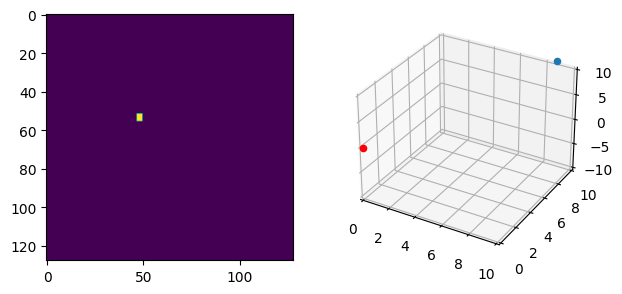

torch.Size([50, 1, 128, 128])


In [6]:
sin_data = single_data(
    field_depth_m,
    field_height_m,
    fov_deg,
    camera_pos,
    output_length=50,
    img_size=(128, 128)
)

print(sin_data.position_sequence.shape)

for frame, pos in zip(sin_data.image_sequence, sin_data.position_sequence):
    live_imshow(frame[0].cpu(), 
                [pos[0]*sin(radians(pos[1]))*cos(radians(pos[1])), 
                 pos[0]*sin(radians(pos[1]))*sin(radians(pos[2])), 
                 pos[0]*cos(radians(pos[1]))])
    sleep(1/12)

print(sin_data.image_sequence.shape)

In [7]:
def create_training_set(
    num_elements: int,
    output_length: int,
    field_depth_m,
    field_height_m,
    fov_deg,
    camera_pos: dict,
):
    return [
        single_data(
            field_depth_m,
            field_height_m,
            fov_deg,
            camera_pos,
            output_length=output_length,
            img_size=(64, 64),
        )
        for _ in range(num_elements)
    ]

In [8]:
# class SnnNet(nn.Module):
#     def __init__(self, img_size):
#         super(SnnNet, self).__init__()

#         self.Lin1 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
#         self.Leaky1 = snn.Leaky(
#             beta=beta, init_hidden=False, spike_grad=spike_grad, learn_beta=True
#         )
#         self.dropout1 = nn.Dropout(p=0.2)

#         self.Lin2 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
#         self.Leaky2 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)
#         self.dropout2 = nn.Dropout(p=0.2)

#         self.Lin3 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
#         self.Leaky3 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)
#         self.dropout3 = nn.Dropout(p=0.2)

#         self.Lin4 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
#         self.Leaky4 = snn.Leaky(
#             beta=beta,
#             init_hidden=False,
#             spike_grad=spike_grad,
#             output=True,
#             reset_mechanism="none",
#             learn_beta=True,
#         )

#         self.spikeLayers = [
#             self.Lin1,
#             self.Leaky1,
#             self.Lin2,
#             self.Leaky2,
#             self.Lin3,
#             self.Leaky3,
#         ]

#     def forward(self, x) -> list:
#         mem1 = self.Leaky1.reset_mem()
#         mem2 = self.Leaky2.reset_mem()
#         mem3 = self.Leaky3.reset_mem()
#         mem4 = self.Leaky4.reset_mem()

#         self.spike_mem = []
#         self.membrane_mem = []

#         # print(x.shape)
#         for state in range(x.shape[0]):
#             out = x[state].flatten()
#             out = self.Lin1(out)
#             out, mem1 = self.Leaky1(out, mem1)
#             out = self.dropout1(out)

#             # out = self.Lin2(out)
#             # out, mem2 = self.Leaky2(out, mem2)
#             # out = self.dropout2(out)

#             # out = self.Lin3(out)
#             # out, mem3 = self.Leaky3(out, mem3)
#             # out = self.dropout3(out)

#             out = self.Lin4(out)
#             out, mem4 = self.Leaky4(out, mem4)

#             self.membrane_mem += [mem4]
#             self.spike_mem += [out]

#         self.membrane_mem = torch.stack(self.membrane_mem)
#         self.spike_mem = torch.stack(self.spike_mem)
#         return self.spike_mem
#         # return self.membrane_mem

In [9]:
class SnnNet(nn.Module):
    def __init__(self, img_size):
        super(SnnNet, self).__init__()

        self.Lin1 = nn.Linear(img_size[0] * img_size[1], img_size[0] * img_size[1])
        self.Leaky1 = snn.Leaky(
            beta=beta, init_hidden=False, spike_grad=spike_grad, learn_beta=True
        )
        torch.nn.init.kaiming_normal_(self.Lin1.weight, a=0.1)
        self.Lin1.bias.data.zero_()

        self.Conv2 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=3, padding=2)
        self.Leaky2 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)
        torch.nn.init.kaiming_normal_(self.Conv2.weight, a=0.1)
        self.Conv2.bias.data.zero_()

        self.Conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=3, padding=2)
        self.Leaky3 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)
        torch.nn.init.kaiming_normal_(self.Conv3.weight, a=0.1)
        self.Conv3.bias.data.zero_()

        self.Lin4 = nn.Linear(32*8*8, 32*8*8)
        self.Leaky4 = snn.Leaky(
            beta=beta, init_hidden=False, spike_grad=spike_grad, learn_beta=True
        )
        torch.nn.init.kaiming_normal_(self.Lin4.weight, a=0.1)
        self.Lin4.bias.data.zero_()

        self.Deconv5 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=5, stride=3, padding=2)
        self.Leaky5 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)
        torch.nn.init.kaiming_normal_(self.Deconv5.weight, a=0.1)
        self.Deconv5.bias.data.zero_()

        self.Deconv6 = nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=5, stride=3, padding=2)
        self.Leaky6 = snn.Leaky(beta=beta, init_hidden=False, spike_grad=spike_grad)
        torch.nn.init.kaiming_normal_(self.Deconv6.weight, a=0.1)
        self.Deconv6.bias.data.zero_()

        self.Lin7 = nn.Linear(64*64, 64*64)
        self.Leaky7 = snn.Leaky(
            beta=beta, init_hidden=False, spike_grad=spike_grad, learn_beta=True
        )
        torch.nn.init.kaiming_normal_(self.Lin7.weight, a=0.1)
        self.Lin7.bias.data.zero_()

    def forward(self, x) -> list:
        mem1 = self.Leaky1.reset_mem()
        mem2 = self.Leaky2.reset_mem()
        mem3 = self.Leaky3.reset_mem()
        mem4 = self.Leaky4.reset_mem()
        mem5 = self.Leaky4.reset_mem()
        mem6 = self.Leaky4.reset_mem()
        mem7 = self.Leaky4.reset_mem()

        self.spike_mem = []
        self.membrane_mem = []

        # print(x.shape)
        for state in range(x.shape[0]):
            # out = x[state].flatten()
            # out = self.Lin1(out)
            # out, mem1 = self.Leaky1(out, mem1)

            # out = torch.reshape(out, (64, 64)).unsqueeze(0)
            out = self.Conv2(x[state])
            out, mem2 = self.Leaky2(out, mem2)

            out = self.Conv3(out)
            out, mem3 = self.Leaky3(out, mem3)

            out = out.flatten()

            out = self.Lin4(out)
            out, mem4 = self.Leaky4(out, mem4)

            out = torch.reshape(out, (32, 8, 8)).unsqueeze(0)

            out = self.Deconv5(out)
            out, mem5 = self.Leaky5(out, mem5)

            out = self.Deconv6(out)
            out, mem6 = self.Leaky6(out, mem6)

            out = out.flatten()

            # out = self.Lin7(out)
            # out, mem7 = self.Leaky7(out, mem7)

            self.spike_mem += [out]
            self.membrane_mem += [mem3]

        self.membrane_mem = torch.stack(self.membrane_mem)
        self.spike_mem = torch.stack(self.spike_mem)
        return self.spike_mem
        # return self.membrane_mem

In [10]:
net = SnnNet(img_size=img_size).to(device)

In [11]:
def live_imshow(data1, data2, figsize=(7,5), title=''):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize)
    ax1.imshow(data1)
    ax2.imshow(data2)
    plt.title(title)
    plt.show()

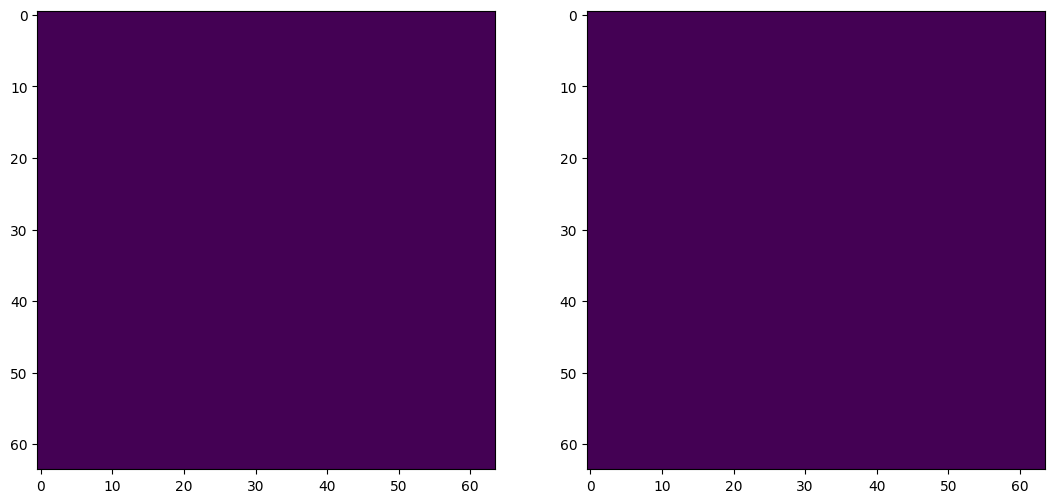

In [12]:
tens = torch.ones(35, 1, img_size[0], img_size[1]).to(device)
images1 = net(tens)

tens = single_data(
            field_depth_m,
            field_height_m,
            fov_deg,
            camera_pos,
            output_length=35,
            img_size=img_size,
        ).image_sequence.to(device)
images2 = net(tens)

print(images2.shape)

for (img1, img2) in zip(images1, images2):
    live_imshow(
        img1.unflatten(0, (64, 64)).cpu().detach().numpy(),
        img2.unflatten(0, (64, 64)).cpu().detach().numpy(),
        figsize=(13, 13)
    )

In [13]:
def live_plot_learning(data, figsize=(7,5), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='center left') # the plot evolves to the right
    plt.show()

In [14]:
num_steps = 35
train_net = create_training_set(100, num_steps, field_depth_m, field_height_m, fov_deg, camera_pos)
spike_recording = [] # record spikes over time
loss_stats = []


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)

In [15]:
num_epoch = 100

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


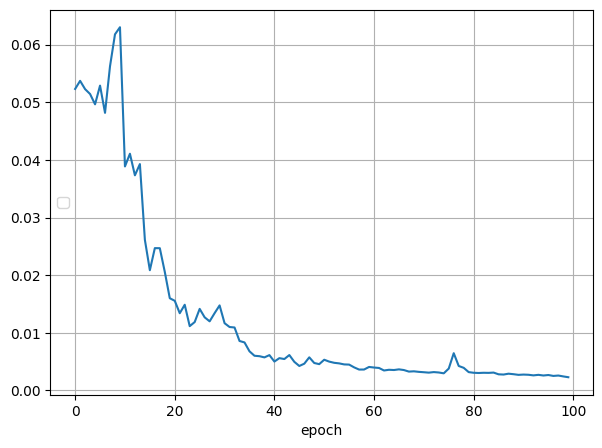

In [16]:
net.train()
for epoch in range(num_epoch):
    random.shuffle(train_net)
    train_iter = iter(train_net)
    ep_loss = 0
    for i, data in enumerate(train_iter):
        target = data.image_sequence[-1][0].flatten()
        target[0] = 0

        # for j in range(5, len(data.image_sequence)): # loop over time
        #     spikes = net(data.image_sequence[0 : j])[-1]
        #     loss = criterion(spikes, target)

        #     optimizer.zero_grad()
        #     loss.backward()
        #     optimizer.step()

        #     ep_loss += loss.item()
        #     live_imshow(
        #         spikes.unflatten(0, (64, 64)).cpu().detach().numpy(),
        #         target.unflatten(0, (64, 64)).cpu().detach().numpy(),
        #         figsize=(13, 13)
        #     )
        spikes = net(data.image_sequence[0 : -10])[-1]
        loss = criterion(spikes, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ep_loss += loss.item()
        # live_imshow(
        #     spikes.unflatten(0, (64, 64)).cpu().detach().numpy(),
        #     target.unflatten(0, (64, 64)).cpu().detach().numpy(),
        #     figsize=(13, 13)
        # ) 
    print(ep_loss / (i + 1))
    loss_stats += [ep_loss / (i + 1)]
    live_plot_learning(loss_stats)


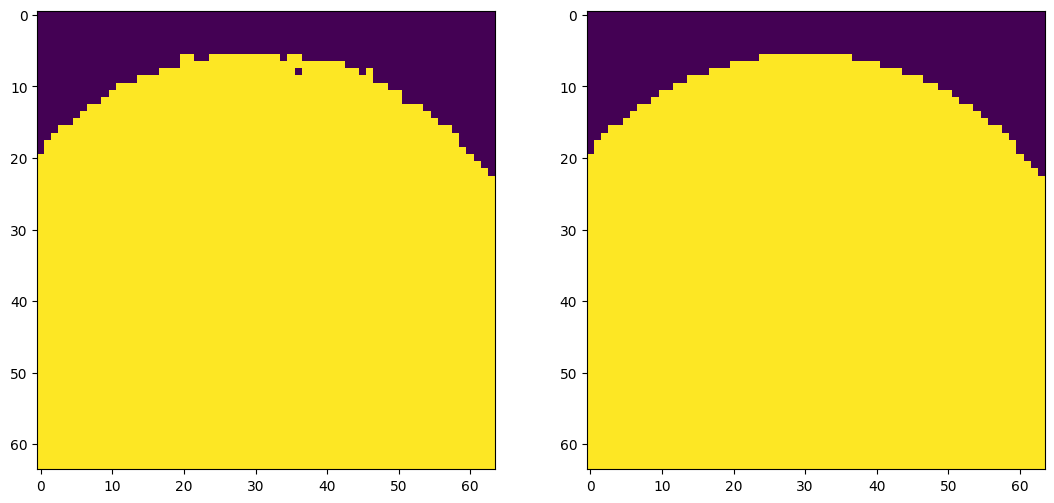

0.002236328125


In [36]:
net.eval()
random.shuffle(train_net)
train_iter = iter(train_net)
ep_loss = 0
for i, data in enumerate(train_iter):
    target = data.image_sequence[-1][0].flatten()
    target[0] = 0

    spikes = net(data.image_sequence[0 : -10])[-1]
    loss = criterion(spikes, target)

    ep_loss += loss.item()
    live_imshow(
        spikes.unflatten(0, (64, 64)).cpu().detach().numpy(),
        target.unflatten(0, (64, 64)).cpu().detach().numpy(),
        figsize=(13, 13)
    )
print(ep_loss / (i + 1))
    # loss_stats += [ep_loss / (i + 1)]


In [25]:
import os
torch.save(net.state_dict(), os.path.join('.', 'models', 'snn', 'v2_conv_MSE.pt'))

In [26]:
val_dataset = create_training_set(100, num_steps, field_depth_m, field_height_m, fov_deg, camera_pos)

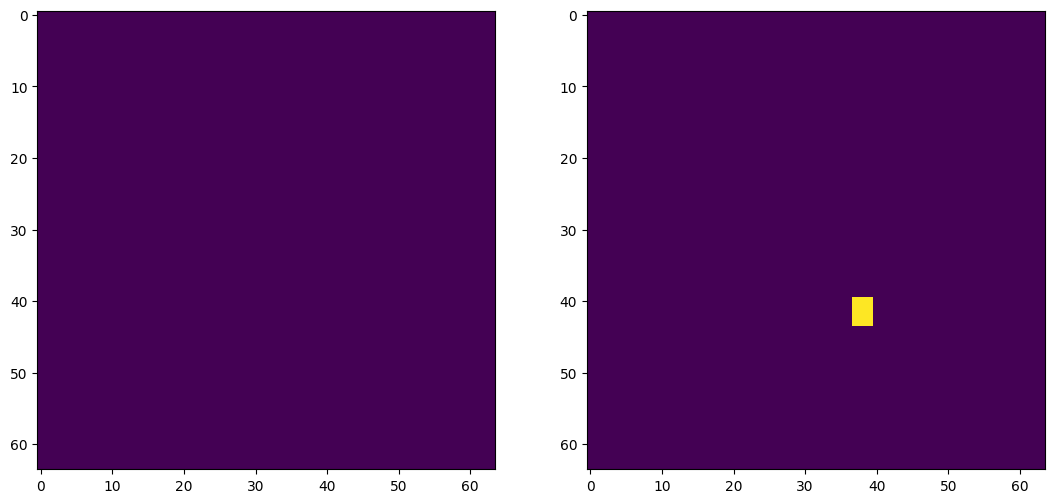

0.0979638671875


In [27]:
net.eval()
random.shuffle(val_dataset)
val_iter = iter(val_dataset)
ep_loss = 0
for i, data in enumerate(val_iter):
    target = data.image_sequence[-1][0].flatten()
    target[0] = 0

    spikes = net(data.image_sequence[0 : -10])[-1]
    loss = criterion(spikes, target)

    ep_loss += loss.item()
    live_imshow(
        spikes.unflatten(0, (64, 64)).cpu().detach().numpy(),
        target.unflatten(0, (64, 64)).cpu().detach().numpy(),
        figsize=(13, 13)
    )
print(ep_loss / (i + 1))
    # loss_stats += [ep_loss / (i + 1)]


Теперь тестируем точность с алгоритмической доработкой: проверяется плотность спайков на выходе и если она превышает 0.5, то будем считать, что авария предсказана вовремя.

In [28]:
def predict_crash(spikes : torch.Tensor):
  return 1 if spikes.mean().item() > 0.5 else 0

In [35]:
random.shuffle(train_net)
avg_acc = 0
for i, data in enumerate(iter(train_net)):
  target = 1 if data.image_sequence[-1].mean() > 0.5 else 0
  spike = net(data.image_sequence)[-1]
  avg_acc += 1 - abs(data.image_sequence[-1].mean() - spike.mean())
  # print(predict_crash(spike), target, data.image_sequence[-1].mean().item(), spikes.mean().item())
  print(avg_acc / (i + 1), data.image_sequence[-1].mean().item(), spike.mean(), target)
print(avg_acc / (i + 1))

tensor(0.9995, device='cuda:0', grad_fn=<DivBackward0>) 0.00048828125 tensor(0., device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.9995, device='cuda:0', grad_fn=<DivBackward0>) 0.00048828125 tensor(0., device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.8902, device='cuda:0', grad_fn=<DivBackward0>) 0.417236328125 tensor(0.0889, device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.9175, device='cuda:0', grad_fn=<DivBackward0>) 0.0029296875 tensor(0.0022, device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.9339, device='cuda:0', grad_fn=<DivBackward0>) 0.00048828125 tensor(0., device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.9448, device='cuda:0', grad_fn=<DivBackward0>) 0.00048828125 tensor(0., device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.9502, device='cuda:0', grad_fn=<DivBackward0>) 0.00634765625 tensor(0.0242, device='cuda:0', grad_fn=<MeanBackward0>) 0
tensor(0.9563, device='cuda:0', grad_fn=<DivBackward0>) 0.00048828125 tensor(0., device='cuda:0', grad_fn=<MeanBa